<a href="https://colab.research.google.com/github/jakobtroidl/OpenVinoClassification/blob/master/customdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import models
import torch.nn as nn
import os
import torch.optim as optim
import pickle
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.classification import Accuracy
import matplotlib.pyplot as plt

In [ ]:
with open("att_dict_simplified.p", "rb") as file:
    data = pickle.load(file)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, split = 'train', name = 'biased_cars_1'):

        root = os.path.join(os.getcwd(), name)
        folders = [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]
        self.all_data = []


        # Define transform to convert image to tensor
        self.transform = transforms.Compose([
            transforms.ToTensor()  # Converts to tensor and scales values to [0,1]
        ])

        for folder in folders:
            im_dir = os.path.join(root, folder, split, "images")
            im_names = os.listdir(im_dir)
            im_names = [os.path.join(im_dir, im) for im in im_names if im in data]
            self.all_data += im_names

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.all_data)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        # Load data and get label
        X = self.transform(Image.open(self.all_data[idx]))
        y = torch.tensor(data[os.path.basename(self.all_data[idx])], dtype=torch.uint8)
        y = y[-1]

        return X, y

In [ ]:
train_dataset = CustomDataset(data, split='train')
val_dataset = CustomDataset(data, split='val')

torch.Size([3, 256, 256]) tensor(3, dtype=torch.uint8)


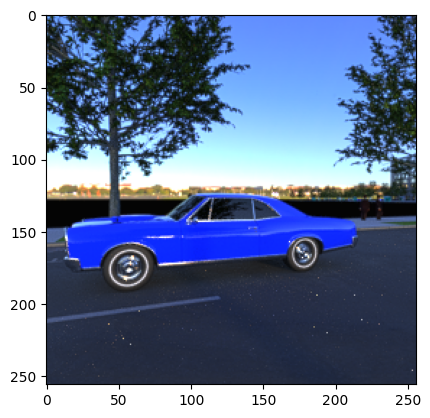

In [ ]:
im, label = train_dataset[0]
print(im.shape, label)

# plot image
plt.imshow(im.permute(1, 2, 0))

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 18)  # Replace last FC layer to 18 output layers
model = model.cuda()


/groups/turaga/home/troidlj/miniconda3/envs/niiv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/groups/turaga/home/troidlj/miniconda3/envs/niiv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()  # Classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [ ]:
num_epochs = 5
acc = Accuracy(task="multiclass", num_classes=18).cuda()

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for epoch in range(num_epochs):

    running_loss = []
    running_acc = []

    model.train()

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        acc.update(outputs, labels)


    tl = sum(running_loss) / len(train_loader)
    train_loss.append(tl)
    train_acc.append(acc.compute().item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {tl}")
    print(f"Accuracy: {acc.compute().item()}")

    acc.reset()
    model.eval()

    eval_loss = []
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        eval_loss.append(loss.item())
        acc.update(outputs, labels)

    el = sum(eval_loss) / len(val_loader)
    val_loss.append(el)
    val_acc.append(acc.compute().item())
    print(f"Validation Loss: {el}")
    print(f"Validation Accuracy: {acc.compute().item()}")
    acc.reset()

print("Training complete!")


Epoch 1/5, Loss: 2.966488125471942
Accuracy: 0.08290307968854904
Validation Loss: 2.926137730053493
Validation Accuracy: 0.07350689172744751
Epoch 2/5, Loss: 2.8736530451648004
Accuracy: 0.08895117044448853
Validation Loss: 2.7884190223654923
Validation Accuracy: 0.12455334514379501
Epoch 3/5, Loss: 2.7540969374608855
Accuracy: 0.11845404654741287
Validation Loss: 2.458981717362696
Validation Accuracy: 0.20469626784324646
Epoch 4/5, Loss: 2.1700978977138665
Accuracy: 0.2609529495239258
Validation Loss: 1.6686681591734593
Validation Accuracy: 0.4139867424964905
Epoch 5/5, Loss: 1.5779755886852918
Accuracy: 0.45552441477775574
Validation Loss: 1.2800716757926405
Validation Accuracy: 0.5441551804542542
Training complete!


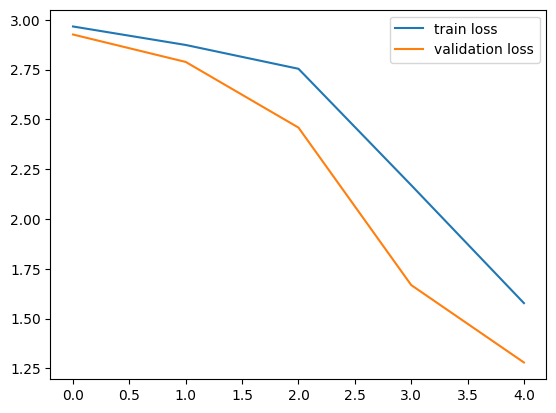

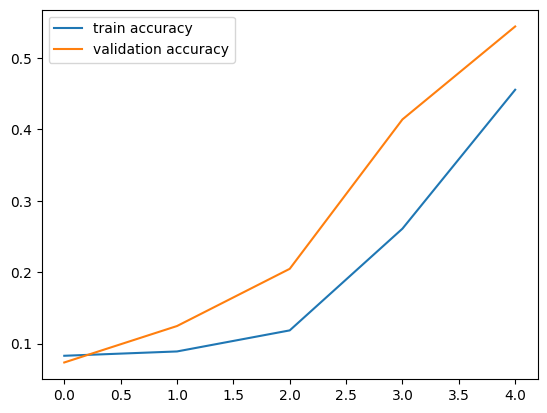

In [ ]:
# plot train and validation loss as line chart
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.show()

# plot train and validation accuracy as line chart
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.show()

Question 1. Examine your accuracy and loss plots.

_(a) Do the overall trends you observe for loss and accuracy make sense? (i.e., should they be increasing or decreasing?) [0.25 points]_
They make sense. The loss is decreasing and the accuracy is increasing. However, performance numbers are overall still pretty low.


_(b) What would you expect to happen if you trained the model for a huge number of epochs? (e.g., 1 million epochs). Specifically, what do you think would happen to the training loss, the validation loss, the training accuracy, and the validation accuracy?_
The model would likely overfit. Training loss would be really low, while the val and training loss would increase. Adding regularization would help prevent this. Training accuracy would be really high, while the val accuracy would decrease.

Question 2. When evaluating a model’s performance, it is important to keep in mind what the model’s accuracy would be “at chance,” i.e. if it learned nothing during training.

_(a) Let’s say the model truly learns nothing, and guesses one of the 18 classes completely at random for each image. What would you expect its accuracy to be on the validation set? [0.25 points]_
1/18 = 0.05555555555555555

_(b) Now let’s say the model learns only a trivial piece of information about the dataset: which class is the most common. What would the model’s accuracy be on the validation set if it always guessed the class that is most common in the training set? [0.25 points]_
That depends on the class label distribution. If the most common class is 40% of the data, then the accuracy would be 40%.